<a href="https://colab.research.google.com/github/zhiyuan-95/db-vae/blob/main/debiasing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install comet_ml --quiet
import comet_ml
# TODO: ENTER YOUR API KEY HERE!! instructions above
COMET_API_KEY = "ROr5Iwf4PjYLL2ZhtmHtYHhoP"

# Import Tensorflow 2.0
import tensorflow as tf
import random
import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import gc
# Download and import the MIT 6.S191 package
!pip install mitdeeplearning --quiet
import mitdeeplearning as mdl


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.1/775.1 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 48.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.0/151.0 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 151.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 132.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.1/278.1 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.9 MB/s eta 0:00:00


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [2]:
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

1263889489/1263889489 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step
Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


In [9]:
### Create a Comet experiment to track our training run ###
def create_experiment(project_name, i):
  # end any prior experiments
  if 'experiment' in locals():
    experiment.end()

  # initiate the comet experiment for tracking
  experiment = comet_ml.Experiment(
                  api_key=COMET_API_KEY,
                  project_name=project_name)
  # log our hyperparameters, defined above, to the experiment
  for param, value in params.items():
    experiment.log_parameter(param, value[i])
  experiment.flush()
  return experiment

In [10]:
### Define the CNN model ###

n_filters = 12 # base number of convolutional filters

'''Function to define a standard CNN model'''
def make_standard_classifier(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

standard_classifier = make_standard_classifier()

In [11]:
### Define the decoder portion of the DB-VAE ###

n_filters = 12 # base number of convolutional filters, same as standard CNN
latent_dim = 100 # number of latent variables

def make_face_decoder_network(latent):
  # Functionally define the different layer types we will use
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=4*4*6*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(4, 4, 6*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

In [12]:
### VAE Reparameterization ###

"""Reparameterization trick by sampling from an isotropic unit Gaussian.
# Arguments
    z_mean, z_logsigma (tensor): mean and log of varience of latent distribution (Q(z|X))
# Returns
    z (tensor): sampled latent vector
"""
def sampling(z_mean, z_logsigma):
  # By default, random.normal is "standard" (ie. mean=0 and std=1.0)
  z_logsigma = tf.clip_by_value(z_logsigma, -100, 3.0)
  sigma = tf.exp(0.5*z_logsigma)
  eps = tf.random.normal(tf.shape(sigma))
  eps = tf.clip_by_value(eps, -3,3)
  z = z_mean + sigma * eps
  return z

In [13]:
### Defining and creating the DB-VAE ###

class DB_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(DB_VAE, self).__init__()
    self.latent_dim = latent_dim

    # Define the number of outputs for the encoder. Recall that we have
    # `latent_dim` latent variables, as well as a supervised output for the
    # classification.
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_classifier(num_encoder_dims)
    self.decoder = make_face_decoder_network(latent_dim)

  # function to feed images into encoder, encode the latent space, and output
  #   classification probability
  def encode(self, x, training = False):
    # encoder output
    encoder_output = self.encoder(x, training = training)
    # classification prediction
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)

    # latent variable distribution parameters
    z_mean = encoder_output[:, 1:self.latent_dim+1]
    z_logsigma = encoder_output[:, self.latent_dim+1:]
    return y_logit, z_mean, z_logsigma

  # VAE reparameterization: given a mean and logsigma, sample latent variables
  def reparameterize(self, z_mean, z_logsigma):
    z = sampling(z_mean, z_logsigma)
    return z

  # Decode the latent space and output reconstruction
  def decode(self, z, training = False):
    reconstruction = self.decoder(z,training=training)
    return reconstruction

  # The call function will be used to pass inputs x through the core VAE
  def call(self, x, training=False):
    # Encode input to a prediction and latent space
    y_logit, z_mean, z_logsigma = self.encode(x, training=training)
    z = self.reparameterize(z_mean, z_logsigma)
    recon = self.decode(z,training=training)
    return y_logit, z_mean, z_logsigma, recon

  # Predict face or not face logit for given input x
  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

# VAE

***vae loss fucntion***

In [81]:
### Defining the VAE loss function ###

def vae_loss_function(x, x_recon, mu, logsigma, c2, c3):

  # L_(KL):  this examines how much the latent variables are close to unit normal distribution
  # which means it forces the latent variable to get closer to the unit normal distribution
  # and how much does it close to unit normal dis is depend on the kl_weight
  KL_loss = tf.reduce_sum(tf.exp(0.5*logsigma) + tf.square(mu) - tf.ones_like(mu) - 0.5*logsigma, axis = 1)
  # examine the difference between the output image and the input image
  reconstruction_loss = tf.reduce_mean(tf.abs(x - x_recon), axis = [1,2,3])
  vae_loss = c2*reconstruction_loss+c3*KL_loss
  return vae_loss,c2*reconstruction_loss,c3*KL_loss

In [155]:
### Loss function for DB-VAE ###
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma, c, eps=1e-8):
    vae_loss, recon, KL = vae_loss_function(x, x_pred, mu, logsigma, c[1], c[2])
    classification_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit))
    face_indicator = tf.cast(tf.equal(y, 1), tf.float32)
    vae_loss = tf.expand_dims(vae_loss, axis = 0)
    vae_loss_faces = vae_loss@face_indicator / (tf.reduce_sum(y) + eps)
    total_loss = c[0]*classification_loss + vae_loss_faces[0][0]
    return total_loss, classification_loss,vae_loss_faces[0][0], KL, recon

In [156]:
x,y = loader.get_batch(10000)
c = (1,0.2,0.0002)
dbvae = DB_VAE(latent_dim)
y_logit, z_mean, z_logsigma, x_recon = dbvae(x, training=True)
loss, classification, vae_loss_faces,KL, recon = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma,c)

# DB-VAE architecture

In [119]:
def get_z(images, dbvae, batch_size = 1024):
  N = images.shape[0]
  z = np.zeros((N, dbvae.latent_dim))
  for start_ind in range(0, N, batch_size):
    end_ind = min(start_ind+batch_size, N+1)
    batch = (images[start_ind:end_ind]).astype(np.float32)/255
    y_logit, z_mean, z_logsigma = dbvae.encode(batch)
    z_out = dbvae.reparameterize(z_mean, z_logsigma)
    z[start_ind:end_ind] = z_out
  return z

In [120]:
### Resampling algorithm for DB-VAE ###

'''Function that recomputes the sampling probabilities for images within a batch
      based on how they distribute across the training data'''
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0):
    print("Recomputing the sampling probabilities")
    z = get_z(images, dbvae)
    # sampling probabilities for the images, initialized to 1.0 for each image and latent dimension
    training_sample_p = np.ones_like(z)

    # consider the distribution for each latent variable
    for i in range(dbvae.latent_dim):

        latent_distribution = z[:,i]
        # generate a histogram of the latent distribution
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)

        # we set the first(the smallest) element and last(the largest) element appeared in the set to -inf and inf|
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')

        # call the digitize function to find which bins in the latent distribution
        # every data sample falls in to
        #
        bin_idx = np.digitize(z[:,i], bin_edges, right=True)

        # smooth the density function
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)

        # hist_smoothed_density[bin_idx-1] lookup operation to find the probability density associated with each mu
        # invert the density function
        p = 1.0/(hist_smoothed_density[bin_idx-1])

        # normalize probabilities for the current latent dimension
        p = p/np.sum(p)

        # Assign probabilities to the corresponding column in training_sample_p
        training_sample_p[:, i] = np.sqrt(p)

  #  print(training_sample_p)
    training_sample_p = tf.reduce_prod(training_sample_p, axis=1)
    # final normalization of the combined probabilities
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

In [121]:
# if the distribution is too extreme, then it means there are few data points going to have very large probability
# which means the model will only focus on those minority points, which means it most like going to affect the perfomance of the model.

In [122]:
def compute_predicted_mean(model_forward_fn, val_groups, eps=1e-6):
    group_means = []
    for g in val_groups:
        logits= model_forward_fn.predict(np.asarray(g, np.float32))
        probs = tf.sigmoid(logits).numpy().reshape(-1)
        group_means.append(float(np.mean(probs)))
    return group_means

def compute_validation(group_means):
    predicted_mean = float(np.mean(group_means))
    return predicted_mean

def compute_db_validation(group_means):
  gm = np.asarray(group_means, dtype=np.float64)
  return float(np.max(gm) - np.min(gm))

def validation(model_forward_fn, val_groups, eps=1e-6):
  gm = compute_predicted_mean(model_forward_fn, val_groups)
  val_score = compute_validation(gm)
  db_val_score = compute_db_validation(gm)
  del gm
  return val_score, db_val_score

In [123]:
class EMASmoother:
    def __init__(self, beta=0.90):
        self.beta = beta
        self.state = None
    def update(self, x):
        x = float(x)
        self.state = x if self.state is None else self.beta*self.state + (1-self.beta)*x
        return self.state

class EarlyStopper:
    def __init__(self, patience=3):
        """
        patience: #epochs with no improvement allowed
        min_delta: absolute (or relative if use_relative=True) improvement threshold
        """
        self.patience = patience
        self.best_val = float("-inf")   # higher is better
        self.best_epoch = -1
        self.bad_epochs = 0
        self.should_stop = False

    def update(self, val_score, epoch):
        if val_score>self.best_val:
            self.best_val = val_score
            self.best_epoch = epoch
            self.bad_epochs = 0
        else:
            self.bad_epochs += 1
            if self.bad_epochs >= self.patience:
                self.should_stop = True

        return self.should_stop ,self.best_val,self.best_epoch


In [124]:
def checkAndLog(early, experiment, loss, val_score, dbval_score, epoch):
  should_stop,best_val, best_epoch = early.update(val_score, epoch=epoch)
  experiment.log_metric("loss_ema",           loss,                 step=epoch)
  experiment.log_metric("val",            val_score,            step=epoch)
  experiment.log_metric("dbval",          dbval_score,          step=epoch)
  experiment.log_metric('best_val',       best_val,              step=epoch)
  experiment.log_metric('best_epoch',     best_epoch,              step=epoch)
  return should_stop, best_epoch

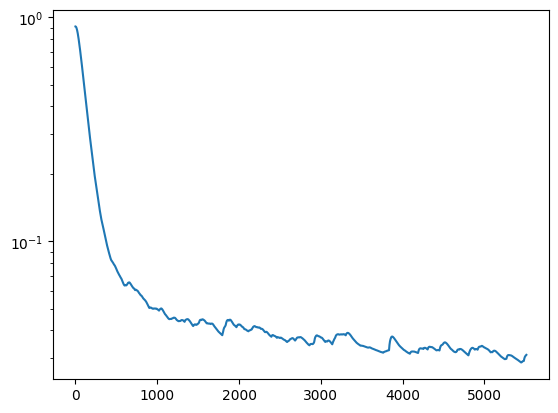

 Expmt 1/20 |Trial 1/3 |Epoch 2/15 |Smooth 0.2 |BS=35 | LR=0.000163:  92%|█████████▏| 2899/3140 [00:48<00:05, 44.59it/s]

In [ ]:
### Training the DB-VAE ###
num_expt = 20
trial_per_expt = 3
#validation set
test_faces = mdl.lab2.get_test_faces()
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]
epoch_max = 15
# Hyperparameters
bin = 10
latent_dim = 100
smoothing = 0.2 #, 0.6, 1
c =(1,0.2,0.0002) # weight on classification loss, reconstruction loss, KL, loss
params = dict(
  batch_size = [random.choice([x for x in range(20,70,5)]) for _ in range(num_expt)],
  learning_rate = [np.round(random.uniform(5e-5,1e-3),6)for _ in range(num_expt)],
  smoothing_fact = [smoothing for _ in range(num_expt)]
)
for iter in range(num_expt):
  for j in range(trial_per_expt):
    total_loss,classification_loss, KL, recon, vae_loss_faces,eval = [],[],[],[],[],[]
    experiment = create_experiment(f"DBVAE_c{c}", iter)
    optimizer = tf.keras.optimizers.Adam(params["learning_rate"][iter], clipnorm=1.0)
    loss_history = mdl.util.LossHistory(smoothing_factor=0.99)
    plotter = mdl.util.PeriodicPlotter(sec=18, scale='semilogy')
    if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
    dbvae = DB_VAE(latent_dim)
    @tf.function
    def debiasing_train_step(x, y):
        with tf.GradientTape() as tape:
            y_logit, z_mean, z_logsigma, x_recon = dbvae(x, training=True)
            loss, classification,vae_loss, KL, recon = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma,c)
        grads = tape.gradient(loss, dbvae.trainable_variables)
        optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
        return loss, classification, vae_loss, KL, recon
    all_faces = loader.get_all_train_faces()
    early = EarlyStopper()

    # The training loop -- outer loop iterates over the number of epochs
    step = 0
    for epoch in range(epoch_max):
#      IPython.display.clear_output(wait=True)
      loss_smoother = EMASmoother(beta=0.95)
      p_faces = get_training_sample_probabilities(all_faces, dbvae,bins=bin, smoothing_fac=params['smoothing_fact'][iter])
      # get a batch of training data and compute the training step
      for idx in tqdm(range(loader.get_train_size()//params["batch_size"][iter]),
                  desc=f" Expmt {iter+1}/{num_expt} |"
                  f"Trial {j+1}/{trial_per_expt} |"
                  f"Epoch {epoch+1}/{epoch_max} |"
                  f"Smooth {params['smoothing_fact'][iter]} |"
                f"BS={params['batch_size'][iter]} | LR={params['learning_rate'][iter]:.6f}"):

        # load a batch of data
        (x, y) = loader.get_batch(params["batch_size"][iter], p_pos=p_faces)
        # loss optimization
        loss, classification, vae , KL, recon= debiasing_train_step(x, y)
        loss_smooth = loss_smoother.update(loss.numpy().mean())
        loss_history.append(loss_smooth)
        plotter.plot(loss_history.get())
        if idx%20==0:
          experiment.log_metric("loss", loss, step=step)
          experiment.log_metric('loss_smooth', loss_smooth, step=step)
          experiment.log_metric('classification', classification, step=step)
          experiment.log_metric('vae', vae, step=step)
          experiment.log_metric('KL', np.mean(KL), step=step)
          experiment.log_metric('recon', np.mean(recon), step=step)
        step += 1
        del x, y, loss, classification, KL, recon, vae , loss_smooth
# regular validation and debiasing validation for every epoch
      loss_ema = float(loss_history.get()[-1])
      val_score, dbval_score = validation(dbvae, test_faces)
# early stopping and log the experiments
      should_stop, best_epoch = checkAndLog(early, experiment, loss_ema, val_score, dbval_score, epoch)
      if should_stop:
          print(f"[EarlyStop] epoch={epoch+1} ; best_epoch={best_epoch+1}")
          break
      del should_stop, best_epoch, loss_ema, val_score, dbval_score
    del loss_history
    tf.keras.backend.clear_session()
    gc.collect()
    experiment.end()